In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import e
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
import math

In [2]:
# input file1
out = pd.read_csv("C:/Users/akash\Documents/GlobalLandTemperaturesByCountry.csv", 
                  parse_dates=True, index_col=0)

In [3]:
# filter all data to Australia only and only 100 years
# changing this to 108 years

In [4]:
out.loc[out['Country']=='Australia']

,AverageTemperature,AverageTemperatureUncertainty,Country
dt,,,
1852-07-01,14.116,1.530,Australia
1852-08-01,15.330,1.400,Australia
1852-09-01,18.740,1.446,Australia
1852-10-01,21.984,1.493,Australia
1852-11-01,24.073,1.466,Australia
...,...,...,...
2013-05-01,19.377,0.229,Australia
2013-06-01,16.018,0.251,Australia
2013-07-01,15.933,0.187,Australia


In [5]:
out=out.loc[out.index.year > 1909]
out=out.loc[out.index.year<=2012] 

In [6]:
print('Null Values: \n',out.isnull().sum())
out=out.ffill()

Null Values: 
 AverageTemperature               769
AverageTemperatureUncertainty     38
Country                            0
dtype: int64


In [7]:
print('Null Values fixed: \n',out.isnull().sum())

Null Values fixed: 
 AverageTemperature               0
AverageTemperatureUncertainty    0
Country                          0
dtype: int64


In [8]:
#drop columns country,uncertainity
out=out.drop('AverageTemperatureUncertainty',1)
out=out.drop('Country',1)

In [9]:
out['Year']=out.index.year + (out.index.month-1)/12  #converting to decimal
out['Month'] = out.index.month
out['Days delta'] = (out.index -  out.index[0]).days

In [10]:
#0=summer,1=autumn,2=winter,3=spring
out['Season'] = [1 if month >= 3 and month <= 5 else 2 if month >= 6 and month <= 8 else 3 if month >= 9 and month <= 11 else 0 for month in out['Month']]

In [11]:
# what about adding a seasonal delta? eg subtract the seasonal average from the yearly average?
#out_yearly_mean = out.resample('A').mean()
ma = out.rolling(window=12).mean()
out['MA'] = ma['AverageTemperature']
out['Season offset'] = out['AverageTemperature'] - ma['AverageTemperature']

In [12]:
out

,AverageTemperature,Year,Month,Days delta,Season,MA,Season offset
dt,,,,,,,
1910-01-01,-1.238,1910.000000,1,0,0,NaN,NaN
1910-02-01,0.638,1910.083333,2,31,0,NaN,NaN
1910-03-01,1.124,1910.166667,3,59,1,NaN,NaN
1910-04-01,3.269,1910.250000,4,90,1,NaN,NaN
1910-05-01,7.996,1910.333333,5,120,1,NaN,NaN
...,...,...,...,...,...,...,...
2012-08-01,18.946,2012.583333,8,37468,2,21.737500,-2.791500
2012-09-01,22.609,2012.666667,9,37499,3,21.713083,0.895917
2012-10-01,23.482,2012.750000,10,37529,3,21.589417,1.892583


In [13]:
print(out['AverageTemperature'].describe())
print(out['AverageTemperature'].shape)
out['AverageTemperature'].shape

count    298953.000000
mean         18.888508
std          10.484783
min         -37.177000
25%          13.240000
50%          23.290000
75%          26.411000
max          38.842000
Name: AverageTemperature, dtype: float64
(298953,)


(298953,)

In [14]:
#resampling
# reduce the rows - by averaging fo rthe graph
out_years = out.resample('A').mean()
#out_quarters = out.resample('Q').mean()
#out_quarters = out.resample('Q', how=['mean', np.min, np.max])
#out_years = out.resample('A', how=['mean', 'min', 'max'])
#out_years_10 = out.resample('10A', how=['mean', 'min', 'max'])
out_years_10 = out.resample('10A').mean()

In [15]:
out_years

,AverageTemperature,Year,Month,Days delta,Season,MA,Season offset
dt,,,,,,,
1910-12-31,18.380081,1910.458333,6.5,166.500000,1.5,18.932140,-0.507267
1911-12-31,18.408202,1911.458333,6.5,531.500000,1.5,18.279772,0.128430
1912-12-31,18.464741,1912.458333,6.5,897.333333,1.5,18.598135,-0.133394
1913-12-31,18.491490,1913.458333,6.5,1262.500000,1.5,18.387970,0.103520
1914-12-31,18.660602,1914.458333,6.5,1627.500000,1.5,18.634489,0.026113
...,...,...,...,...,...,...,...
2008-12-31,19.452983,2008.458333,6.5,35961.333333,1.5,19.441261,0.011722
2009-12-31,19.574902,2009.458333,6.5,36326.500000,1.5,19.492192,0.082711
2010-12-31,19.657980,2010.458333,6.5,36691.500000,1.5,19.696163,-0.038183


In [16]:
doSeasonal=True

sd:  dt
1910-01-01    -1.238
1910-02-01     0.638
1910-03-01     1.124
1910-04-01     3.269
1910-05-01     7.996
               ...  
2009-08-01    16.423
2009-09-01    13.177
2009-10-01     5.614
2009-11-01     5.539
2009-12-01    -0.823
Length: 1200, dtype: float64
sd:  count    1200.000000
mean        5.712107
std         6.926974
min       -12.097000
25%         0.341500
50%         5.137500
75%        11.819000
max        19.858000
dtype: float64
Seasonal resid:  dt
1910-01-01   NaN
1910-02-01   NaN
1910-03-01   NaN
1910-04-01   NaN
1910-05-01   NaN
              ..
2009-08-01   NaN
2009-09-01   NaN
2009-10-01   NaN
2009-11-01   NaN
2009-12-01   NaN
Name: resid, Length: 1200, dtype: float64
Seasonal s:  dt
1910-01-01   -7.968693
1910-02-01   -8.975884
1910-03-01   -7.045014
1910-04-01   -3.421572
1910-05-01    1.618869
                ...   
2009-08-01    9.843746
2009-09-01    5.951408
2009-10-01    1.340639
2009-11-01   -2.468656
2009-12-01   -5.583554
Name: seasonal, Length: 12

<Figure size 432x288 with 0 Axes>

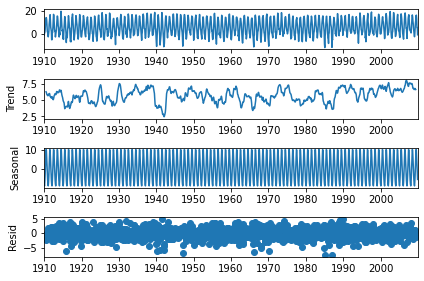

In [17]:
if doSeasonal:
    seasonal_data = out[0:1200] # 12 months * 2 years
    sx = seasonal_data.index
    sy = seasonal_data['AverageTemperature'].values
    seasonal_series = pd.Series(sy, index=sx)
    print("sd: ", seasonal_series)
    print("sd: ", seasonal_series.describe())
    seasonal_result = seasonal_decompose(seasonal_series, model='additive')
    f = plt.figure()
    f = seasonal_result.plot()
    f.savefig("test-seasonal-plot.png")
    print("Seasonal resid: " , seasonal_result.resid)
    print("Seasonal s: " , seasonal_result.seasonal)
    print("Seasonal trend: " , seasonal_result.trend)

In [18]:
print("SD: ", out_years["AverageTemperature"].std())
print("SD: ", out_years_10["AverageTemperature"].std())

SD:  0.33377703906878087
SD:  0.36374931362676455


In [19]:
sx

DatetimeIndex(['1910-01-01', '1910-02-01', '1910-03-01', '1910-04-01',
               '1910-05-01', '1910-06-01', '1910-07-01', '1910-08-01',
               '1910-09-01', '1910-10-01',
               ...
               '2009-03-01', '2009-04-01', '2009-05-01', '2009-06-01',
               '2009-07-01', '2009-08-01', '2009-09-01', '2009-10-01',
               '2009-11-01', '2009-12-01'],
              dtype='datetime64[ns]', name='dt', length=1200, freq=None)

In [20]:
#Testing with Linear regression

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [22]:
x=out_years["Year"].values.reshape(-1,1)
y = out_years['AverageTemperature'].values

In [23]:
y

array([18.38008125, 18.40820243, 18.46474097, 18.49148958, 18.66060243,
       18.71123993, 18.55187743, 18.24255417, 18.39374028, 18.53186146,
       18.54267049, 18.60775417, 18.50415313, 18.56541944, 18.62185903,
       18.58891319, 18.86793229, 18.73918194, 18.73845903, 18.48581944,
       18.84472257, 18.7554    , 18.74608264, 18.55832396, 18.81882361,
       18.72231076, 18.81061944, 18.95794688, 18.87344514, 18.81152917,
       18.70296424, 18.88144549, 18.76261076, 18.8170434 , 18.85743472,
       18.80656736, 18.92441424, 19.04098785, 18.77332874, 18.72651309,
       18.61869777, 18.80681001, 18.83725652, 18.887     , 18.61281379,
       18.68946125, 18.32128429, 18.79136968, 18.97317661, 18.85669067,
       18.91824348, 18.9546454 , 18.72587277, 18.70734979, 18.61376337,
       18.5502915 , 18.89760322, 18.66645782, 18.63820645, 18.80323148,
       18.82573388, 18.62066667, 18.69775309, 18.90458025, 18.66372942,
       18.77846982, 18.51509294, 18.95334602, 18.76139575, 18.94

In [24]:
len(y)

103

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

In [27]:
len(x_train)

82

In [28]:
len(y_train)

82

In [29]:
# Model Import and Build 

In [30]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(x_train, y_train)

pred = regressor.predict(x_test)

Text(0, 0.5, 'Y-Train')

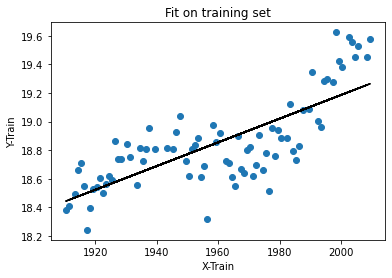

In [31]:
# Visualization
## Check the fitting on training set
plt.scatter(x_train, y_train)
plt.plot(x_train, regressor.predict(x_train), color='black')
plt.title('Fit on training set')
plt.xlabel('X-Train')
plt.ylabel('Y-Train')

Text(0, 0.5, 'Y-Test')

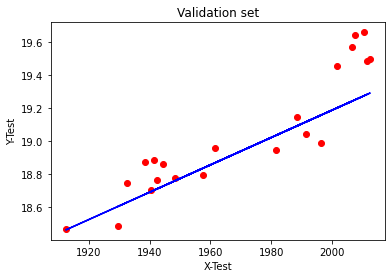

In [32]:
## Check fitting on validation set
plt.scatter(x_test, y_test, color='r')
plt.plot(x_test, pred, color='b')
plt.title('Validation set')
plt.xlabel('X-Test')
plt.ylabel('Y-Test')

In [65]:
print("Prediction 2019: ", regressor.predict([[2019]]))

Prediction 2019:  [19.34408709]


In [67]:
print("Regression Prediction 1990: ", regressor.predict([[1990]]))
print("Regression Prediction 2019: ", regressor.predict([[2019]]))
print("Regression Prediction 2050: ", regressor.predict([[2050]]))

Regression Prediction 1990:  [19.10354416]
Regression Prediction 2019:  [19.34408709]
Regression Prediction 2050:  [19.60121918]


In [35]:
x_test

array([[2010.45833333],
       [2001.45833333],
       [1944.45833333],
       [1941.45833333],
       [1988.45833333],
       [1991.45833333],
       [2011.45833333],
       [1957.45833333],
       [1948.45864921],
       [2007.45833333],
       [1938.45833333],
       [2006.45833333],
       [1961.45833333],
       [1912.45833333],
       [1940.45833333],
       [1942.45833333],
       [1996.45833333],
       [1981.45833333],
       [2012.45833333],
       [1929.45833333],
       [1932.45833333]])

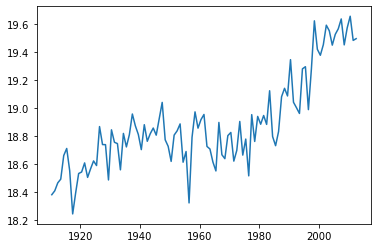

In [36]:
plt.plot(x,y)

In [37]:
# The coefficients
print("Coefficients: \n", regressor.coef_)

Coefficients: 
 [0.00829458]


In [38]:
from sklearn.metrics import mean_squared_error, r2_score

In [39]:
print("Accuracy: ", regressor.score(x,y))

Accuracy:  0.6386264478837798


In [40]:
# The mean squared error
MSE_Linear=mean_squared_error(y_test, pred)
print("Mean squared error: %.2f" % mean_squared_error(y_test, pred))

Mean squared error: 0.03


In [41]:
RMSE = math.sqrt(MSE_Linear)

In [42]:
RMSE

0.18649783544579923

In [44]:
# The coefficient of determination[Adjusted R Square]: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, pred))

Coefficient of determination: 0.74


In [43]:
# The mean squared error
print("Mean squared error: ", np.mean((regressor.predict(x) - y) ** 2))

Mean squared error:  0.03986871398070714


In [45]:
#SVR Model

In [46]:
  svr = SVR(kernel = "rbf", C = 1e3, gamma = 0.1, epsilon = 0.1)

In [47]:
 svr.fit(x,y)

SVR(C=1000.0, gamma=0.1)

In [48]:
y_preds_svr = svr.predict(x)

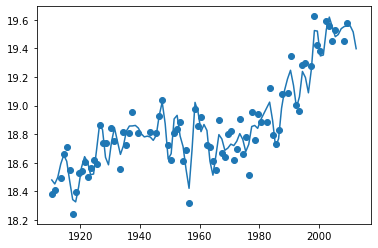

In [49]:
plt.plot(x, y_preds_svr,'-', markersize=1, label="SVR")
plt.scatter(x_train, y_train)

In [63]:
print("SVR Accuracy: ", svr.score(x,y))
print("SVR Prediction 1990: ", svr.predict([[1990]]))
print("SVR Prediction 2019: ", svr.predict([[2019]]))
print("SVR Prediction 2050: ", svr.predict([[2050]]))

SVR Accuracy:  0.9334733411786047
SVR Prediction 1990:  [19.23196008]
SVR Prediction 2019:  [18.8876216]
SVR Prediction 2050:  [18.88612662]


In [51]:
model = make_pipeline(PolynomialFeatures(degree=2), Ridge(alpha=1.0))

In [52]:
model.fit(x, y)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('ridge', Ridge())])

In [54]:
 y_preds2 = model.predict(x)

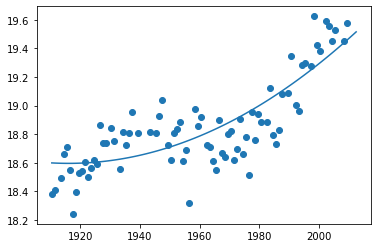

In [55]:
plt.plot(x, y_preds2, '-', markersize=1, label="Poly F (3) + Ridge")
plt.scatter(x_train, y_train)

In [56]:
print("Accuracy: ", model.score(x,y))

Accuracy:  0.7277371320329418


In [57]:
print("Mean squared error: ", np.mean((model.predict(x) - y) ** 2))

Mean squared error:  0.03003753414432141


In [62]:
print("Ridge Prediction 1990: ", model.predict([[1990]]))
print("Ridge Prediction 2019: ", model.predict([[2019]]))
print("Ridge Prediction 2050: ", model.predict([[2050]]))

Ridge Prediction 1990:  [19.13712661]
Ridge Prediction 2019:  [19.64481784]
Ridge Prediction 2050:  [20.37164256]


In [131]:
#Model Comparison

In [59]:
MSE_Linear=mean_squared_error(y_test, pred)
print("Mean squared error: %.2f" % mean_squared_error(y_test, pred))
RMSE = math.sqrt(MSE_Linear)
print("RMSE: %.2f" % RMSE)
print("Coefficient of determination: %.2f" % r2_score(y_test, pred))
print("Accuracy Linear Regression: ", regressor.score(x,y))

Mean squared error: 0.03
RMSE: 0.19
Coefficient of determination: 0.74
Accuracy Linear Regression:  0.6386264478837798


In [60]:
#print("Mean squared error: ", np.mean((svr.predict(x_test) - y_test) ** 2))
MSE2=mean_squared_error(y_test, svr.predict(x_test))
print("Mean squared error: ",MSE2)
RMSE_SVR = math.sqrt(MSE2)
print(" Root Mean squared error: ",RMSE_SVR)
print("Coefficient of determination: %.2f" % r2_score(y_test, svr.predict(x_test)))
print("SVR Accuracy: ", svr.score(x,y))

Mean squared error:  0.006504186510011447
 Root Mean squared error:  0.08064853693658333
Coefficient of determination: 0.95
SVR Accuracy:  0.9334733411786047


In [61]:
print("Accuracy Ridge Regression: ", model.score(x,y))
print("Mean squared error: %.2f" % mean_squared_error(y_test, model.predict(x_test)))
MSE3=mean_squared_error(y_test, model.predict(x_test))  
RMSE3 = math.sqrt(MSE3)
print("RMSE:",RMSE3)
print("Coefficient of determination: %.2f" % r2_score(y_test, model.predict(x_test)))

Accuracy Ridge Regression:  0.7277371320329418
Mean squared error: 0.02
RMSE: 0.14305436186510753
Coefficient of determination: 0.84


In [71]:
print("Regression Prediction 1990: ", regressor.predict([[1990]]))
print("Regression Prediction 2019: ", regressor.predict([[2019]]))
print("Regression Prediction 2030: ", regressor.predict([[2030]]))
print("Regression Prediction 2050: ", regressor.predict([[2050]]))

Regression Prediction 1990:  [19.10354416]
Regression Prediction 2019:  [19.34408709]
Regression Prediction 2030:  [19.43532751]
Regression Prediction 2050:  [19.60121918]


In [72]:
print("Ridge Prediction 1990: ", model.predict([[1990]]))
print("Ridge Prediction 2019: ", model.predict([[2019]]))
print("Ridge Prediction 2030: ", model.predict([[2030]]))
print("Ridge Prediction 2050: ", model.predict([[2050]]))

Ridge Prediction 1990:  [19.13712661]
Ridge Prediction 2019:  [19.64481784]
Ridge Prediction 2030:  [19.88094572]
Ridge Prediction 2050:  [20.37164256]


In [73]:
print("SVR Prediction 1990: ", svr.predict([[1990]]))
print("SVR Prediction 2019: ", svr.predict([[2019]]))
print("SVR Prediction 2030: ", svr.predict([[2030]]))
print("SVR Prediction 2050: ", svr.predict([[2050]]))

SVR Prediction 1990:  [19.23196008]
SVR Prediction 2019:  [18.8876216]
SVR Prediction 2030:  [18.88612662]
SVR Prediction 2050:  [18.88612662]
